### Steer the flashlight, and see bulbs change color on the V-REP scene.

##### First: make bulbs change color.

In [1]:
%pylab inline
import rospy, tf
import vrep_common.srv
import geometry_msgs.msg, std_msgs.msg
import time
import matplotlib.pyplot as plt
import pylab
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
rospy.init_node('colored_bulbs')

In [3]:
srv = rospy.ServiceProxy('/vrep/simRosSetFloatSignal', vrep_common.srv.simRosSetFloatSignal)

In [20]:
srv('/sphere0/color/r', 100)
srv('/sphere0/color/g', 100)
srv('/sphere0/color/b', 100)

result: 1

##### Next: flashlight model

In [4]:
class Light:
    listener=tf.TransformListener()
    def __init__(self, frame_id, cone_h=10.0, cone_r=10.0):
        self.frame_id = frame_id
        self.cone_h = cone_h
        self.cone_r = cone_r
        
    def lightval(self, pt):
        headtrans, headrot = Light.listener.lookupTransform(
                            '/world', self.frame_id, rospy.Time(0))
        
        headmat = Light.listener.fromTranslationRotation(headtrans, headrot)
        point0= headmat * np.matrix([[0, 0, 0, 1]]).T
        direction_vector = headmat * np.matrix([[1, 0, 0, 1]]).T - point0
        
        dummypos_vect = np.matrix([[pt[0], pt[1], pt[2], 1]]).T
       
        dist = np.dot(direction_vector.A1, dummypos_vect.A1)
        dist_vect = dist * direction_vector
        
        radius_at_point = (dist / self.cone_h) * self.cone_r
        
        rel_vect = dummypos_vect - point0
        to_get_distance = (rel_vect - dist_vect).A1
        ortho_dist = np.sqrt(np.dot(to_get_distance, to_get_distance))
        light = radius_at_point - ortho_dist
        return 0 if light <=0 else light
        

<matplotlib.colorbar.Colorbar instance at 0x7f5568f426c8>

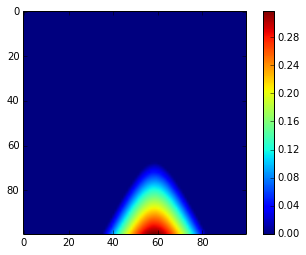

In [5]:
l = Light('/head0', 20., 10.)
xs = np.linspace(-1.0, 1.0, 100)
ys = np.linspace(-1.0, 1.0, 100)
img=np.ndarray(shape=(len(ys), len(xs)), dtype=float)
for i in xrange(len(xs)):
    for j in xrange(len(ys)):
        x = xs[i]
        y = ys[j]
        img[i][j] = l.lightval((x,y,0))
plt.imshow(img)
plt.colorbar()

In [6]:
class Sphere:
    srv = rospy.ServiceProxy('/vrep/simRosSetFloatSignal', vrep_common.srv.simRosSetFloatSignal)
    listener=tf.TransformListener()
    
    def __init__(self, sid):
        self.sid=sid
        self.frame_id='/sphere{0}'.format(sid)
        self.r_sig='/sphere{0}/color/r'.format(sid)
        self.g_sig='/sphere{0}/color/g'.format(sid)
        self.b_sig='/sphere{0}/color/b'.format(sid)
        
    def set_color(self, r, g, b):
        Sphere.srv(self.r_sig, r)
        Sphere.srv(self.g_sig, g)
        Sphere.srv(self.b_sig, b)

    def get_position(self):
        trans, rot = Sphere.listener.lookupTransform(
                            '/world', self.frame_id, rospy.Time(0))
        return trans

In [7]:
s = Sphere(0)

In [8]:
s.set_color(100,0,0)

In [9]:
s.get_position()

(0.6229458451271057, 0.3706493079662323, 0.04999992251396179)

In [10]:
l.lightval(_34)

NameError: name '_34' is not defined

In [11]:
l = Light('/head0', 10., 10.)

In [12]:
spheres = []
for i in range(13):
    spheres.append(Sphere(i))

In [11]:
%%timeit
spheres[0].get_position()

100000 loops, best of 3: 5.58 µs per loop


In [12]:
%%timeit
spheres[0].set_color(0,0,0)

1 loops, best of 3: 373 ms per loop


In [ ]:
%%timeit
spheres[0].set_color(0,0,0)

In [13]:
%%timeit
l.lightval(pos)

10000 loops, best of 3: 147 µs per loop


In [15]:
for s in spheres:
    s.set_color(100, 100, 100)

In [ ]:
while True:
    for s in spheres:
        pos = s.get_position()
        lightval = l.lightval(pos)
        color=10. * lightval
        s.set_color(color, color, color)
#     time.sleep(.01)
    